## Assignment 2
In this exercise you will:
 * Compute an implicit MLS function approximating a 3D point cloud with given (but possibly unnormalized) normals.
 * Sample the implicit function on a 3D volumetric grid.
 * Apply the marching tets algorithm to extract a triangle mesh of this zero level set.
 * Experiment with various MLS reconstruction parameters.

Your main task is to construct an implicit function `f(x)` defined on all `x`  R<sup>3</sup> whose zero level set contains (or at least passes near) each input point. That is, for every point `pi` in the point cloud, we want `f(pi) = 0`. Furthermore, `∂f` (the isosurface normal) evaluated at each point cloud location should approximate the point's normal provided as input.

In [ ]:
import numpy as np
import igl
import meshplot as mp
import math

In [ ]:
# Utility function to generate a tet grid
# n is a 3-tuple with the number of cell in every direction
# mmin/mmax are the grid bounding box corners
# returns V - vertices of the grid

def tet_grid(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    delta = mmax-mmin
    
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    deltaz = delta[2]/(nz-1)
    
    T = np.zeros(((nx-1)*(ny-1)*(nz-1)*6, 4), dtype=np.int64)
    V = np.zeros((nx*ny*nz, 3))

    mapping = -np.ones((nx, ny, nz), dtype=np.int64)


    index = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                mapping[i, j, k] = index
                V[index, :] = [i*deltax, j*deltay, k*deltaz]
                index += 1
    assert(index == V.shape[0])
    
    tets = np.array([
        [0,1,3,4],
        [5,2,6,7],
        [4,1,5,3],
        [4,3,7,5],
        [3,1,5,2],
        [2,3,7,5]
    ])
    
    index = 0
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nz-1):
                indices = [
                    (i,   j,   k),
                    (i+1, j,   k),
                    (i+1, j+1, k),
                    (i,   j+1, k),

                    (i,   j,   k+1),
                    (i+1, j,   k+1),
                    (i+1, j+1, k+1),
                    (i,   j+1, k+1),
                ]
                
                for t in range(tets.shape[0]):
                    tmp = [mapping[indices[ii]] for ii in tets[t, :]]
                    T[index, :]=tmp
                    index += 1
                    
    assert(index == T.shape[0])
    
    V += mmin
    return V, T

# Reading point cloud

In [ ]:
pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
mp.plot(pi, shading={"point_size": 8})

In [37]:
def generate_points_on_circle(radius, num_points):
    points = []
    for i in range(num_points):
        # Calculate the angle for this point
        angle = 2 * math.pi * i / num_points
        # Calculate x and y coordinates
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        points.append((x, y))
    return points

## Setting up Constraints
Your first step is to build the set of constraint equations by choosing constraint locations and values. Naturally, each point `pi` in the input point cloud should contribute a constraint with target value `f(pi) = di = 0`. But these constraints alone provide no information to distinguish the object's inside (where we want `f < 0`) from its outside (where we want `f > 0`). Even worse, the minimization is likely to find the trivial solution `f = 0` (if it lies in the space of admissible functions). To address these problems, we introduce additional constraints incorporating information from the normals as follows:

  * For each point `pi` in the point cloud, add a constraint of the form `f(pi) = di = 0`.
  * Fix an `eps` value, for instance `eps = 0.01 bounding_box_diagonal`.
  * For each point `pi` compute `pi+ = pi + eps ni`, where `ni` is the normalized normal of `pi`. Check that `pi` is the closest point to `pi+` if not, halve `esp` and recompute `pi+` until this is the case.
    Then, add another constraint equation: `f(pi+) = eps`.
  * Repeat the same process for `-eps`, i.e., add equations of the form `f(pi-) = -eps`. Do not forget to check each time that `pi` is the closest point to `pi-`.
  * Append the tree vectors `pi`, `pi+`, and `pi-` and corresponding `f` to a unique vector `p` and `f`.

After these steps, you should have `3n` equations for the implicit function `f(x)`.

**Important**: explicitty write a function `find_closed_point(point, points)` that retreives the index of the colosest point to `point` in `points`.

![](img/cat.png?raw=true)
Input point cloud for the *cat* mesh and inward/outward value constraints. The green, red and blue labels correspond to inside, outside and on the surface respectively. The blue points in the left figure are the same as the black ones in right figure.

*Relevant `numpy` functions:* `argmin`, `linalg.norm`.

Required output of this section:

 * Plot of the provided point cloud shaded with green, blue, and red dots.

In [4]:
"""
pp = p+ 
npp = p- 
"""
def setupConstraints(pis, v, eps,ps):
    ni = igl.per_vertex_normals(pis, v)  
    f = []
    pps = []  # positive points
    nps = []  # negative points
    for pi in pis: #fill f up to size of points
        f.append(0)
    # compute p+
    for idx, pi in enumerate(pis):
        pp = pi + eps * ni[idx]
        cp = find_closest_point(pp, pis)
        new_eps = eps
        while cp != idx:
            new_eps /= 2  # Reduce step size
            pp = pi + new_eps * ni[idx]
            print("not closest point!")
        pps.append(pp)
        f.append(new_eps)
    # compute p-
    for idx, pi in enumerate(pis):
        npp = pi - eps * ni[idx]  # Negative offset
        cp = find_closest_point(npp, pis)
        new_eps = eps
        while cp != idx:
            new_eps /= 2
            npp = pi - new_eps * ni[idx]
            print("not closest point!")
        nps.append(npp)
        f.append(new_eps)
    p=np.concatenate((pis, pps, nps), axis=0)

    # must be numpy arrays to visualize 
    pps = np.array(pps) 
    nps = np.array(nps) 
    print("length of p = 3n: ", len(p) == (len(pis)+len(pps)+len(nps))) #check to make sure p is correct
    print("length of f = 3n: ", len(f) == (len(pis)*3)) #check to make sure f is correct
    # plot 3 set of points
    plot = mp.plot(pis, shading={"point_color": "blue", "point_size": ps}) # blue = on surface
    plot.add_points(pps, shading={"point_color": "red", "point_size": ps}) # red = outside 
    plot.add_points(nps, shading={"point_color": "green", "point_size": ps}) # green = inside 
    return p,f

def find_closest_point(point, points):
    dist = np.linalg.norm(points - point, axis=1)
    return np.argmin(dist)

p, f = setupConstraints(pi,v,1.5,8)

length of p = 3n:  True
length of f = 3n:  True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

### Create a grid sampling the 3D space
Create a regular volumetric grid around your point cloud: compute the axis-aligned bounding box of the point cloud, enlarge it slightly, and divide it into uniform cells (tets). The grid resolution is configured by
the global variable `resolution`, which can be changed. *Note* the funciton to generate the grid is provided. We call the grid vertices `x` and the tets connecting them `T`.

In [12]:
"""
Creating volumetric grid around point cloud 
"""
minimum = -100000 # temporary value to help us compute the bounding box 
maximum = 100000
resolution = 0.05 # we multiply the box diagonal by this when making the tetrahedral gird

#function to get margins for bounding box 
def createBoundingBox(pis):
    max_x = max_y = max_z = minimum
    min_x = min_y = min_z = maximum
    for pi in pis:
        if pi[0]>max_x:
            max_x=pi[0]
        if pi[0]<min_x:
            min_x=pi[0]
        if pi[1]>max_y:
            max_y=pi[1]
        if pi[1]<min_y:
            min_y=pi[1]
        if pi[2]>max_z:
            max_z=pi[2]
        if pi[2]<min_z:
            min_z=pi[2]
    return min_x, min_y, min_z, max_x, max_y, max_z
    
#function to create a grid 
def createGrid(pis, enlargefactor, n, ps_grid, ps_mesh,showCheck=False):
    margins = createBoundingBox(pis) # compute axis-aligned bounding box of the point cloud 
    enlarged_margins = enlargefactor * np.concatenate([np.floor(margins[:3]), np.ceil(margins[-3:])]) #convert to floor & ceiling to avoid float multiplication error
    bbox_min = enlarged_margins[:3]
    bbox_max = enlarged_margins[-3:]
    box_diag = np.linalg.norm(bbox_max - bbox_min)
    x,T = tet_grid((n,n,n), bbox_min-resolution*box_diag, bbox_max + resolution * box_diag)
    if(showCheck):# show if object fits inside grid
        plot = mp.plot(x, shading={"point_color": "black",  "point_size": ps_grid})
        plot.add_points(pis, shading={"point_color": "blue", "point_size": ps_mesh})
    return x,T
x, T = createGrid(pi,1.1,20, 5,10,True)
print(x.shape)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.5, -25.…

(8000, 3)


### MLS Interpolation
We now use MLS interpolation to construct an implicit function satisfying the constraints as nearly as possible.
We won't define the function with an explicit formula; instead we characterize it as the linear combination of polynomial basis functions that best satisfies the constraints in some sense. At a given point `xi` in `x`, you evaluate this function by finding the "optimal" basis function coefficients (which will vary from point to point!) and using these to combine the basis function values at `xi`.

Complete the appropriate source code sections to evaluate the MLS function at every node `xi` of a regular volumetric
grid containing the input point cloud. As an example, the provided code computes the grid values for an implicit function representing a sphere (MLS wasn't used in
this case since the formula is known analytically).


More specifically, for each grid node `xi` of the grid, evaluate the implicit function `f(xi)`, whose zero level set approximates the point cloud.
Use the moving least squares approximation presented in class and in the tutoring session. You should use the
Wendland weight function with radius configured by `wendlandRadius` and degree `k = 0, 1, 2` polynomial basis functions configured by `polyDegree`. Only use the constraint points with nonzero weight (i.e., points `p` with `||xi - p|| < wendlandRadius`). *Note* if the number of constraint points within `wendlandRadius` is less than twice the number of polynomial coefficients (i.e., 1 for `k = 0`, 4 for `k = 1`, and 10 for `k = 2`), you can assign a large positive (outside) value to the grid point.

Store the field value  `fx = f(xi)` in a  `numpy.array`, using the same ordering as in `x`. Render these values by coloring each grid point red/green depending if they are inside outside (i.e., `fx < 0` or `fx ≥ 0`). You can use the `meshplot.plot(..., c=color)` where `color` is a `n x 3` matrix containing rgb values.

**Important**: explicitty write a function `closest_points(point, points, h)` that retreives the indices all points in `points` that are at distance less than `h` from `point`.

*Relevant `numpy` functions:* `argwhere`, `linalg.solve`.

Required output of this section:

 * Plot of the grid points `x` colored according of being inside or outside the input cloud.


### Notes -- my summary of what we're doing 

From what I understand, what we’re doing with MLS is 
1. fitting a function to the points we had (vector p) and their value at the original f we saved when setting up the constraints (either 0, epsilon, or -epsilon)
2. Once that is fitted, we plug in the points on the grid to that function

The values of the variables:
- x is the point on the grid
- c is a constraint point (p, p+eps, p-eps)
- d is the value of f at the constraint point  (0, eps, -eps)

### MLS equations (background): 
 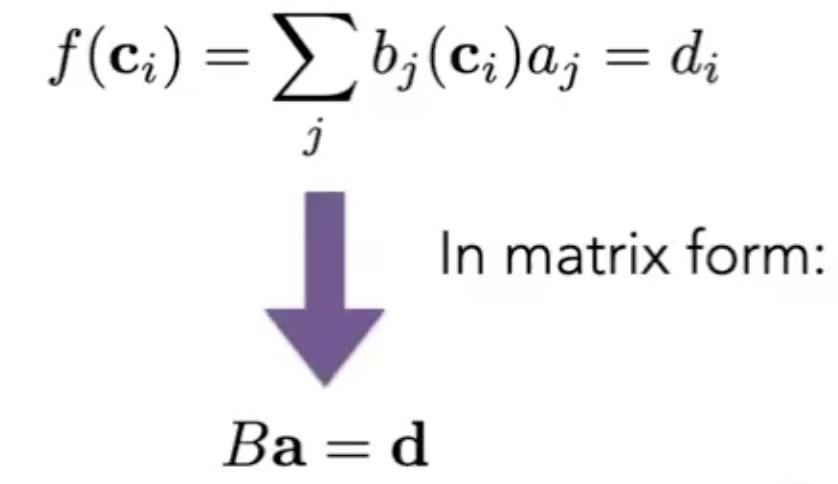
 
- There are 3n constraints
- Columns of B represent the bases
- a contains the weights

 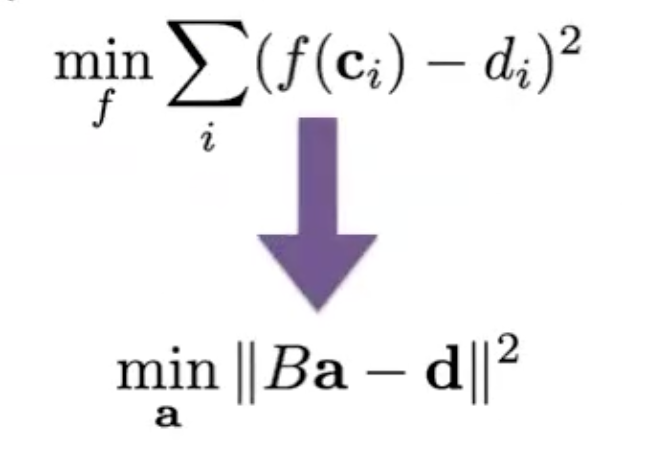
 
- Ba is the value at f(c), d is the constraint value

### MLS equations (real) 

 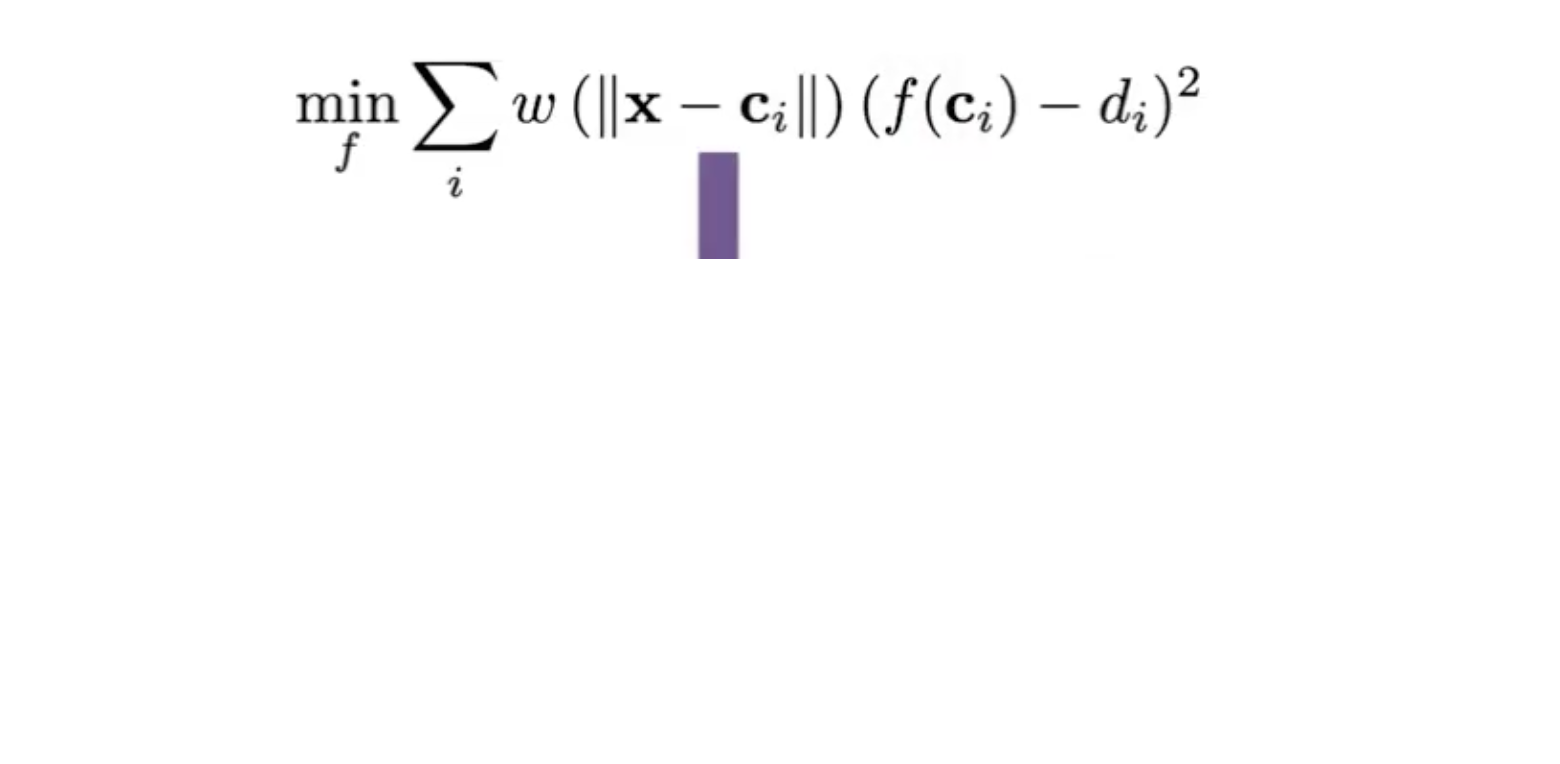
 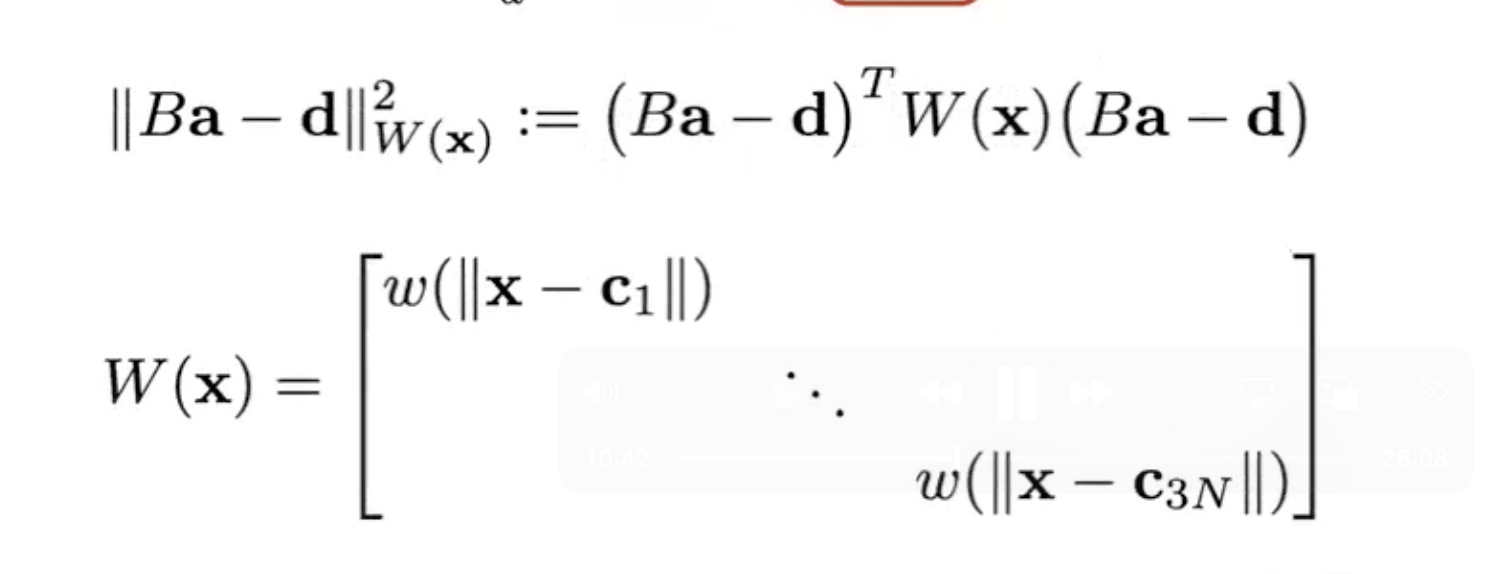

- MLS creates an interpolant around every evaluation point (eval point wld be the nodal points aka the points on the grid)
- diagonal weight matrix

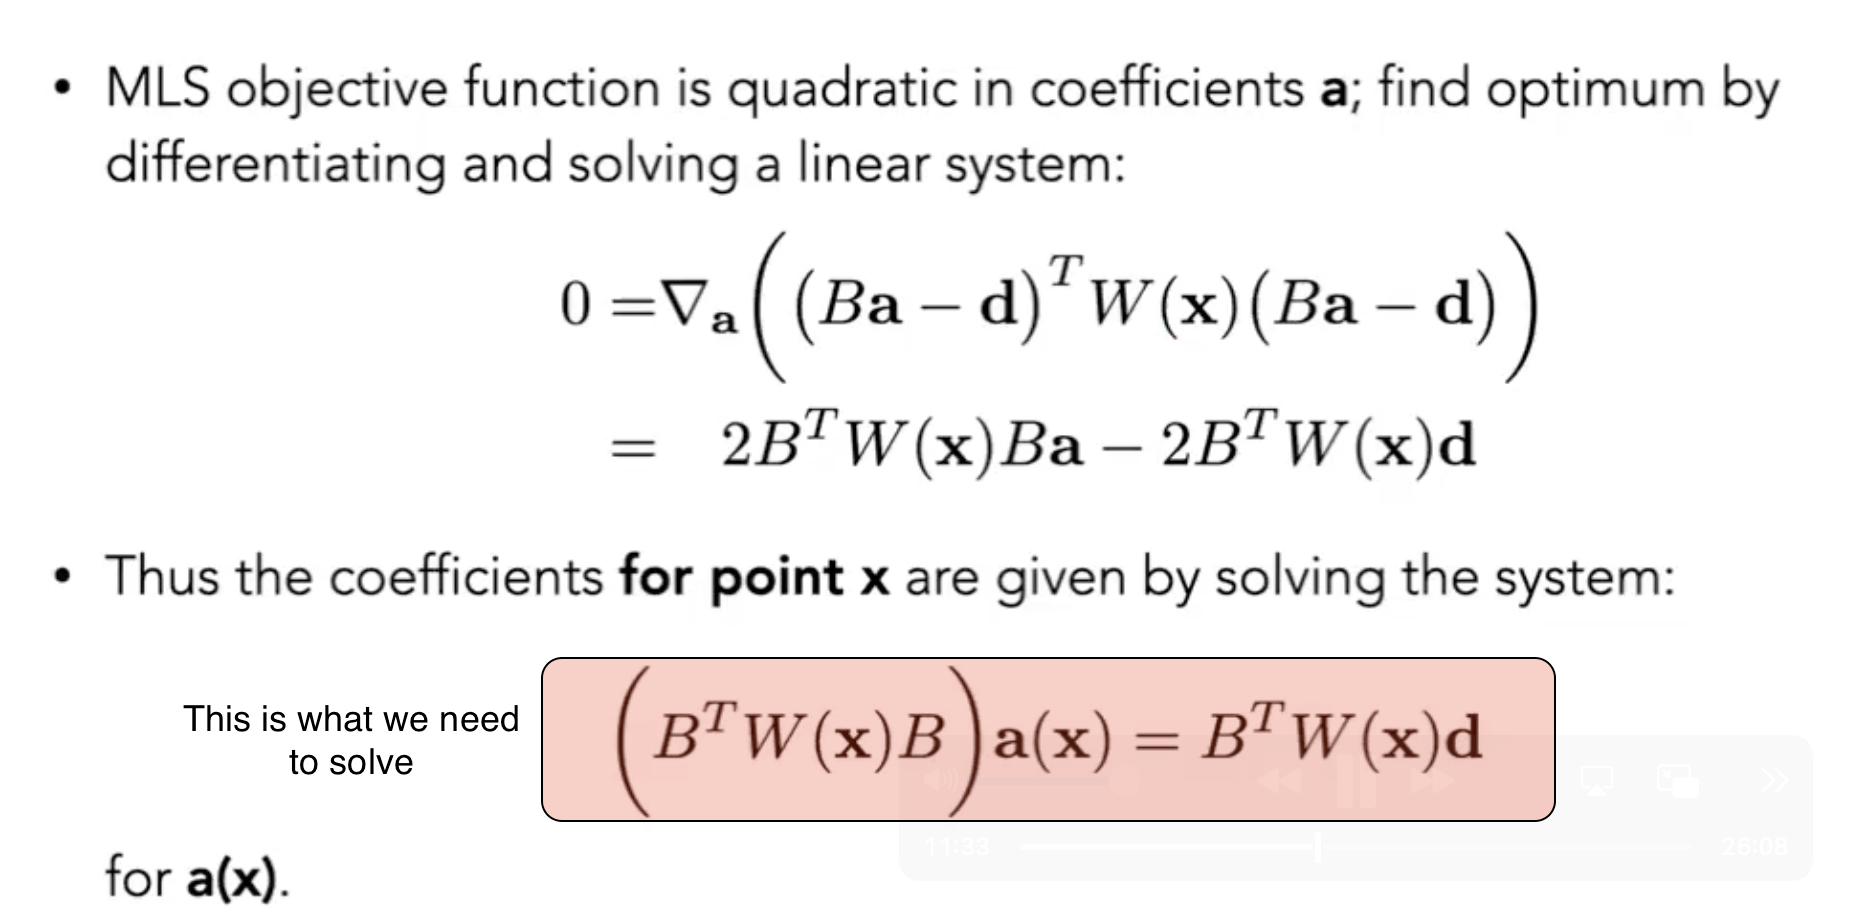

- w depends on gridpoint
- after this, we solve for a(x) ! which are the coefficients of the basis
- B is precomputed!
- Then B*a give us the value for x!! 


In [6]:
pi_cube, v_cube = igl.read_triangle_mesh("data/cube.obj") # reading the file in as an obj 
ni_cube = igl.per_vertex_normals(pi_cube, v)
mp.plot(pi_cube, shading={"point_size": 1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [8]:
p_cube, f_cube = setupConstraints(pi_cube,v_cube,.05,.5)

length of p = 3n:  True
length of f = 3n:  True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [19]:
#def createGrid(pis, enlargefactor, n, ps_grid, ps_mesh,showCheck=False):
x_cube, T_cube = createGrid(pi_cube,1,3, .3,.1, True)
print(x_cube.shape)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

(27, 3)


In [30]:
"""
Goal: find the best f in the span of chosen basis functions 
    f(x) = sum_j b_j(x)a_j, where the basis is a polynomial function 
"""

def mls_interpolate(p,f, normals, x,T, wendlandRadius):
    # We want to solve (B^TW(x)B)a(x)=B^TW(x)d, where W = wendland weight matrix 
    # 1. Compute B (the polynomial basis of x) -- polynomial 3d basis = 1,x,y,z,x^2,y^2,x^2,xy,xz,yz
    ones = np.ones((x.shape[0],1))
    xx,yy,zz = x[:,0:1], x[:,1:2], x[:,2:3] #extracting columns of x
    # print(one, xx,yy,zz)
    B = np.hstack([ones,xx,yy,zz])
    # 2. Compute W 
    # for each evaluation point, evaluate pi, in p, W_ii = w||x-p_i||
    diag_values = []
    for xi in x:
        for pi in p:
            val = wendland(np.linalg.norm(xi-pi,axis=0), wendlandRadius)
            diag_values.append(val)
        # print(val)
    W = np.diag(diag_values)
    # 3. Compute B^TW(x)d
    btw = B.T @ W
    lhs = btw @ f
    # 4. Compute B^TW(x)B
    rhs = btw @ B
    # 5. Compute (B^TW(x)B)a(x)=B^TW(x)d
    a=np.linalg.solve(rhs,lhs)
    return a
    
"""
returns the indices of the points within distance h of point, point
"""
def closest_points(point, points, h):
    close_points = []
    dist = np.linalg.norm(points - point, axis=1)
    for ind, d in enumerate(dist):
        if d<h:
            close_points.append(ind)
    return close_points  

"""
Computes wendland weight 
h is the distance from evaluation point -- wendland radius 
r is the distance ||x - c_i||
"""
def wendland(r, h):
    if (r>=h):
        return 0
    weight = (1-r/h)**4*(4*r/h+1)
    return weight

# mls_interpolate(p,f,v,x,T,1)
mls_interpolate(p_cube,f_cube,v_cube,x_cube,T_cube,1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 648 is different from 27)

In [ ]:
def MLS_interpolate(p,f, normals, x,T, wendlandRadius):
    # a is a column vecor with all parameters
    # b^T is a row vector containing the variables 
    # fit fx to points that minimize it ... 
        # find points nearby, fit fx to those points, evaluate f
    for ind, xin in enumerate(x): 
        close_points_idx = closest_points(xin, x, wendlandRadius) 
        # fx = argmin SUM_i w(||x-pi||)(fx(pi)-f)
    # center = np.array([0., 0., 0.])
    # radius = 1 #change to wendland radius 
    # fx = np.linalg.norm(x-center, axis=1) - radius ## THIS IS WHERE WE WILL PUT IN THE MLS 
    # ind = np.zeros_like(fx)
    # ind[fx >= 0] = 1
    # ind[fx < 0] = -1
    # mp.plot(x, c=ind, shading={"point_size": 0.1,"width": 800, "height": 800})
    # fill in the grid
    # evaluate local MLS interpolant at each grid point x 
    # (B^TW(x)B)a(x)=B^TW(x)d, where W = wendland weight 
    return 0


## Implementing a spatial index to accelerate neighbor calculations

To construct the MLS equations, you will perform queries
to find, for a query point `q`:

    * the closest input point to `q` (needed while constructing inside/outside offset points); and
    * all input points within distance `h` of `q` (needed to select constraints with nonzero weight).


Although a simple loop over all points could answer these queries, it would be slow for large point clouds.
Improve the efficiency by implementing a simple spatial index (a uniform grid at some resolution). By this, we mean binning vertices into their enclosing grid cells and restricting the neighbor queries to visit only the grid cells that could possibly satisfy the query. You can debug
this data structure by ensuring that it agrees with the brute-force for loop implementation.

This part requires changing the two fucntion `find_closed_point` and `closest_points`.

## Using a non-axis-aligned grid.
The point cloud `luigi.off` is not aligned with the canonical axes.
Running reconstruction on an axis-aligned grid is wasteful in this case: many of the grid points will lie far outside the object. Devise an automatic (and general) way to align the grid to the data and implement it.

Required output of this section:

* Plot of the grid with nodes colored according to their implicit function values

## Extracting the surface
You can now use marching tets to extract the zero isosurface from your grid.
The extraction has already been implemented and the surface is displayed. The implicit function obtained from MLS might be noisy and the reconstructed mesh will contain several pieces. Filter out and keep the largest component.

![](img/cat-recon.png?raw=true)

*Relevant `igl` functions:* `marching_tets`, `face_components`.


Required output of this section:

* Plot of the reconstructed surfaces. Experiment with different parameter settings: grid resolution (also anisotropic in the 3 axes), Wendland function radius, and polynomial degree.


## MLS function

In [112]:
# Parameters
bbox_min = np.array([-1., -1., -1.])
bbox_max = np.array([1., 1., 1.])
bbox_diag = np.linalg.norm(bbox_max - bbox_min)

n = 10

In [111]:
# Generate grid n x n x n

x, T = tet_grid((n, n, n), bbox_min - 0.05 * bbox_diag, bbox_max + 0.05 * bbox_diag)

#Compute implicit sphere function

center = np.array([0., 0., 0.])
radius = 1
fx = np.linalg.norm(x-center, axis=1) - radius ## THIS IS WHERE WE WILL PUT IN THE MLS 
print(x)
print(x-center)
print(fx)

[[-1.17320508 -1.17320508 -1.17320508]
 [-1.17320508 -1.17320508 -0.91249284]
 [-1.17320508 -1.17320508 -0.6517806 ]
 ...
 [ 1.17320508  1.17320508  0.6517806 ]
 [ 1.17320508  1.17320508  0.91249284]
 [ 1.17320508  1.17320508  1.17320508]]
[[-1.17320508 -1.17320508 -1.17320508]
 [-1.17320508 -1.17320508 -0.91249284]
 [-1.17320508 -1.17320508 -0.6517806 ]
 ...
 [ 1.17320508  1.17320508  0.6517806 ]
 [ 1.17320508  1.17320508  0.91249284]
 [ 1.17320508  1.17320508  1.17320508]]
[ 1.03205081  0.89353202  0.78259313  0.70462746  0.66427553  0.66427553
  0.70462746  0.78259313  0.89353202  1.03205081  0.89353202  0.74404602
  0.62292061  0.53687599  0.49199399  0.49199399  0.53687599  0.62292061
  0.74404602  0.89353202  0.78259313  0.62292061  0.49199399  0.39791365
  0.34841419  0.34841419  0.39791365  0.49199399  0.62292061  0.78259313
  0.70462746  0.53687599  0.39791365  0.29702702  0.24351813  0.24351813
  0.29702702  0.39791365  0.53687599  0.70462746  0.66427553  0.49199399
  0.34841

In [81]:
# Threshold fx to visualize inside outside

ind = np.zeros_like(fx)
ind[fx >= 0] = 1
ind[fx < 0] = -1
mp.plot(x, c=ind, shading={"point_size": 0.1,"width": 800, "height": 800})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## Marching tets to extract surface

In [90]:
# Marcing tet to extract surface

sv, sf, _, _ = igl.marching_tets(x, T, fx, 0) ## SV AND SF ARE THE VERTICES
mp.plot(sv, sf, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## Optional tasks

<!-- * *(2 points)* Compute the closed-form gradient of the MLS approximation. Suggestion: A good strategy to solve this exercise is to write MLS explicitly in matrix form and then compute its gradient (a good reference for differentiating expressions with matrices can be found in [The Matrix Cookbook](http://orion.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).
 -->
* *(2 points)* In [Interpolating and Approximating Implicit Surfaces from Polygon Soup](http://graphics.berkeley.edu/papers/Shen-IAI-2004-08/index.html) normals are used differently to define the implicit surface. Instead of generating new sample points offset in the positive and negative normal directions, the paper uses the normal to define a linear function for each point cloud point: the signed distance to the tangent plane at the point.
Then the values of these linear functions are interpolated by MLS. Implement Section 3.3 of the paper and append to your report a description of the method and how it compares to the original point-value-based approach.
Estimate a normal for results obtained with single dataset.

* *(1 points)* [Screened Poisson Surface Reconstruction](http://www.cs.jhu.edu/~misha/MyPapers/ToG13.pdf) is a more modern technique that avoids some of the pitfalls of local reconstruction methods. An implementation is provided in [MeshLab](http://www.meshlab.net). A standalone implementation of this method is also provided by the authors [here](http://www.cs.jhu.edu/~misha/Code/PoissonRecon/Version9.01/) with accompanying usage instructions and datasets. Compare your MLS        reconstruction results to the surfaces obtained with this method, and try to understand the differences. Report your findings.